#Esse notebook demostra como executar análise por Modelo de Mistura Espectral no Python. Esse script foi desenvolvido pela Prof Dra Vanessa Bastos (Instagram: @gisdoctor) inspirada por aula do Prof Dr Gustavo Baptista (@profgustavobaptista). Versão: 0.0 de Janeiro de 2022#

#**Em caso de dúvidas você pode me contactar por direct no instagram (@gisdoctor).**#



## **Passo 1 - Instale as bibliotecas necessárias**

Esse passo pode levar alguns minutos, não se assuste.

In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()
!conda install rasterio
!pip install -q pysptools
!pip install ipympl


⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:51
🔁 Restarting kernel...
Solving environment: \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - rasterio


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    affine-2.3.0               |             py_0          16 KB  conda-forge
    attrs-21.4.0               |     pyhd8ed

### **Passo 2 - Importe as bibliotecas**

In [1]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import pysptools.eea as eea 
import pysptools.abundance_maps as amap
import io
from google.colab import files

### **Passo 3  - Importe a a imagem que será analisada**

In [2]:
uploaded = files.upload()

Saving CBERS_4A_WPM_20210921_206_133_L4_CUBO_PAN_RGBN.tif to CBERS_4A_WPM_20210921_206_133_L4_CUBO_PAN_RGBN.tif


# 3.1  Abra a imagem com a biblioteca rasterio e leia as bandas para a variável img e os dados de transformação para coordenadas geográficas para a variável affine.

In [3]:
with rasterio.open(io.BytesIO(uploaded['CBERS_4A_WPM_20210921_206_133_L4_CUBO_PAN_RGBN.tif'])) as src:
# Nessa linha obtemos a informação necessária  para transformar as coordenadas  da matriz raster em coordenadas geográficas
  affine=src.transform
# Aqui lemos os valores da banda e guardamos na variável img
  img=src.read()

## 3.2 Visualize a banda 1 da imagem

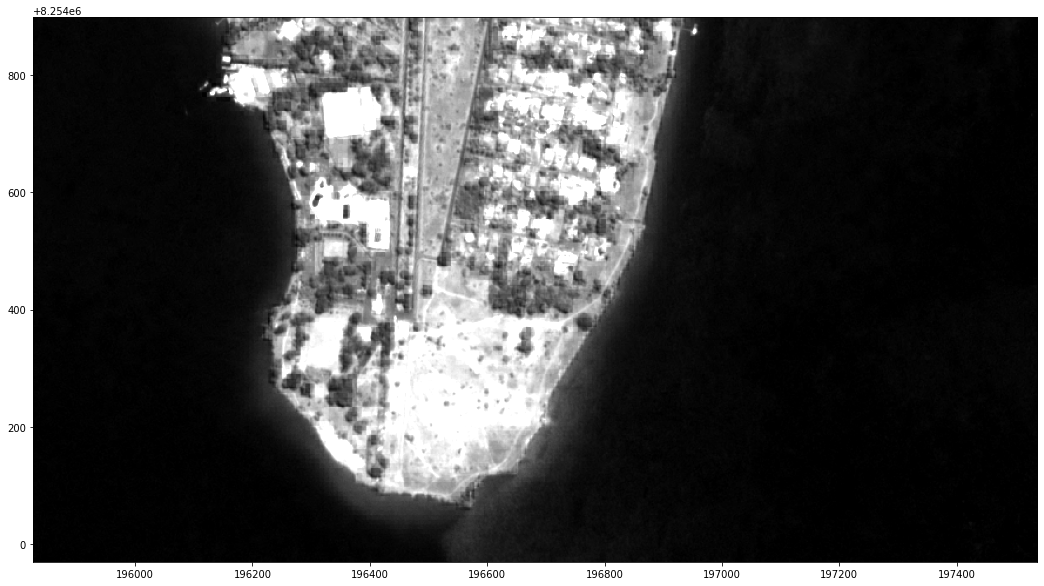

(0.0, 1.0, 0.0, 1.0)

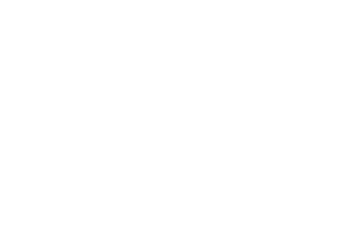

In [4]:
from rasterio.plot import show
fig, ax = plt.subplots(figsize=(18,18))
vmin, vmax = np.percentile(img[0], (5,95))  # 5-95% stretch
show(img[0], cmap='gray', transform=affine, vmin=vmin, vmax=vmax)
plt.axis('off')


## 3.3 Reformate o stack de bandas para garantir que ele siga as dimensões (mxn)xq, onde q é o número de bandas. Usualmente os stacks seguem qx(mXn) por padrão.

In [7]:
img_reshaped=np.stack((img[0],img[1],img[2],img[3]),axis=-1)

## **4 - Extração de endmembers**

# 4.1 Inicialize o algoritmo de extração de enmembers. Nesse caso utilizo o NFINDR [1] da biblioteca pysptools, mas também é possível utilizar Automatic Target Generation Process (ATGP),Fast Iterative Pixel Purity Index (FIPPI) e Pixel Purity Index (PPI).

[1] Proceedings Volume 3753, Imaging Spectrometry V; (1999) https://doi.org/10.1117/12.366289
Event: SPIE's International Symposium on Optical Science, Engineering, and Instrumentation, 1999, Denver, CO, United States

In [8]:
ee = eea.NFINDR()


## 4.2 - Aplique o algoritmo inicializado para encontrar os endmembers.

In [9]:
U = ee.extract(img_reshaped,5,normalize=False,ATGP_init=True)

# **5 - Visualize a informação espectral dos end members encontrados**

## 5.1 Crie uma lista com os comprimentos de onda das bandas da imagem. Eles serão usados no eixo x do gráfico

In [10]:
wave = [0.45,0.52,0.63,0.77,1.55,2.21]

## 5.2 Formate o eixo x como float e crie rótulos para os eixos do gráfico

In [11]:
ee_axes = {} 
ee_axes['wavelength'] = [float(i) for i in wave]
ee_axes['x']='Wavelength'
ee_axes['y']='Reflectance' 

## 5.3 Visualize a informação espectral dos endmembers encontrados

ValueError: ignored

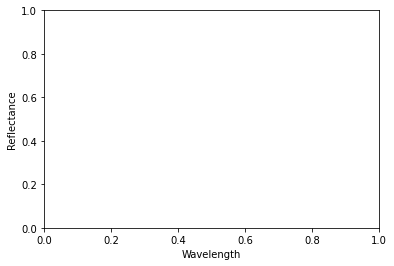

In [12]:
ee.display(axes=ee_axes,suffix='Landsat')

**6 - Mapeamento das imagens fração**




6.1 Inicialize o algoritmo para mapeamento das fraçoes e aplique na  imagem com base nos endmembers encontrados. Nesse caso utilizamos o FCLS (Fully Constrained Least Squares - mínimos quadrados com restrições). Esse procedimento pode demorar alguns minutos dependendo do tamanho da imagem.

In [13]:
am = amap.FCLS()
amaps = am.map(img_reshaped,U,normalize=True) 

6.2 Visualize as imagens fração para identificar qual representa o que.

> Bloco com recuo



/usr/local/lib/python3.7/site-packages/pysptools/abundance_maps/amaps_int.py:127: UserWarning: In abundance_map._plot_abundance_map, the number of abundances map to display is less or equal the number of columns
  warnings.warn('In abundance_map._plot_abundance_map, the number of abundances map to display is less or equal the number of columns')


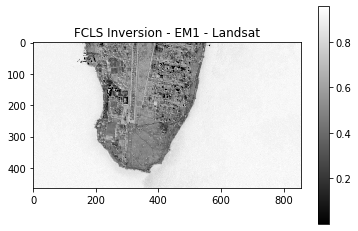

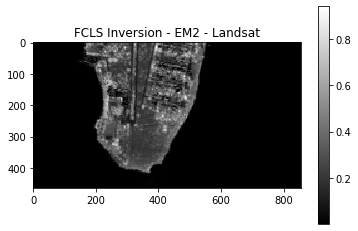

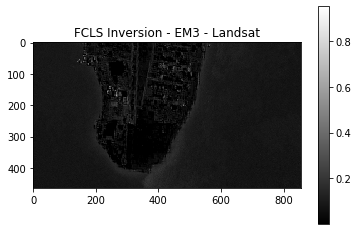

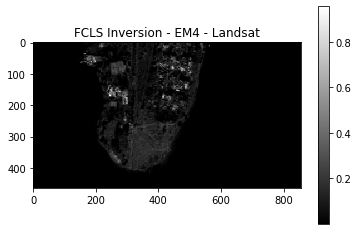

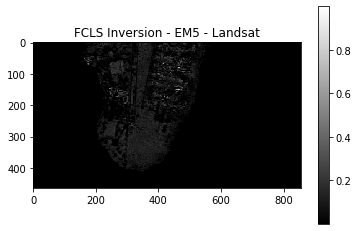

<Figure size 432x288 with 0 Axes>

In [14]:
am.display(colorMap='gray',columns=5,suffix='Landsat')

6.3 Calculei o valor médio das imagens fração para me auxiliar na escolha das frações para composção.

In [15]:
print('Abundance Map Mean Values:')
print('EM1:',np.mean(amaps[:,:,0]))
print('EM2:',np.mean(amaps[:,:,1]))
print('EM3:',np.mean(amaps[:,:,2]))
print('EM4:',np.mean(amaps[:,:,3]))
print('EM5:',np.mean(amaps[:,:,4]))

Abundance Map Mean Values:
EM1: 0.78334945
EM2: 0.08940238
EM3: 0.078535505
EM4: 0.028558945
EM5: 0.020153685


6.4 Separei as imagens fração criando uma variável por banda

In [16]:
EM1=(amaps[:,:,0])
EM2=(amaps[:,:,1])
EM3=(amaps[:,:,2])
EM4=(amaps[:,:,3])
EM5=(amaps[:,:,4])


6.5 Visualizei as bandas novamente mas agora em tamanho maior

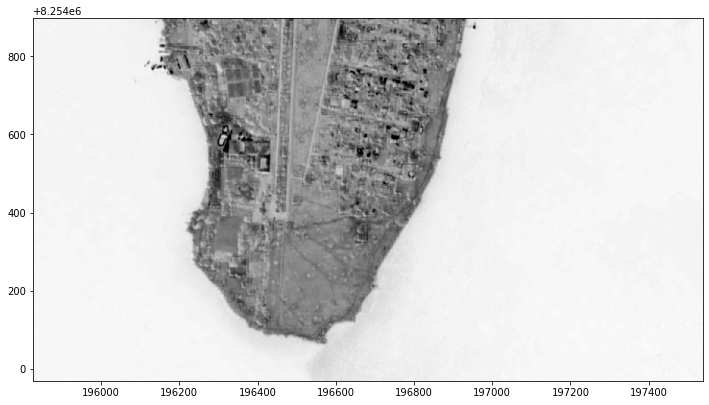

(0.0, 1.0, 0.0, 1.0)

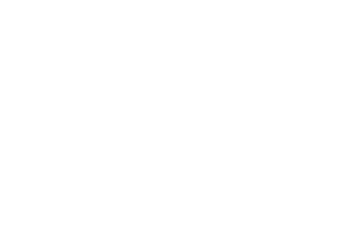

In [17]:
fig, ax = plt.subplots(figsize=(12,12))
show(EM1, cmap='gray', transform=affine)
plt.axis('off')

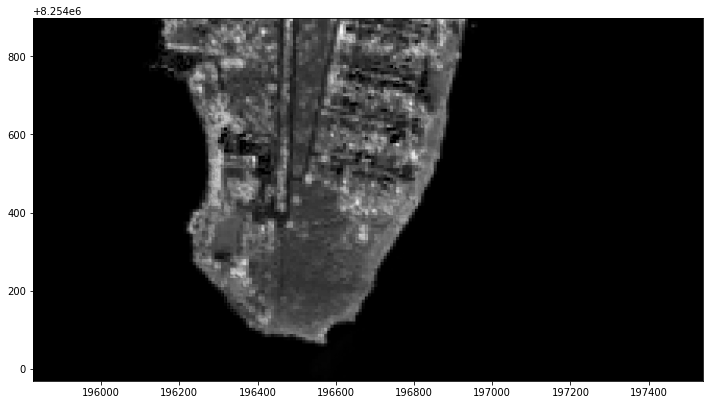

(0.0, 1.0, 0.0, 1.0)

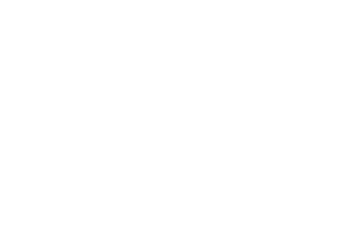

In [18]:
fig, ax = plt.subplots(figsize=(12,12))
show(EM2, cmap='gray', transform=affine)
plt.axis('off')

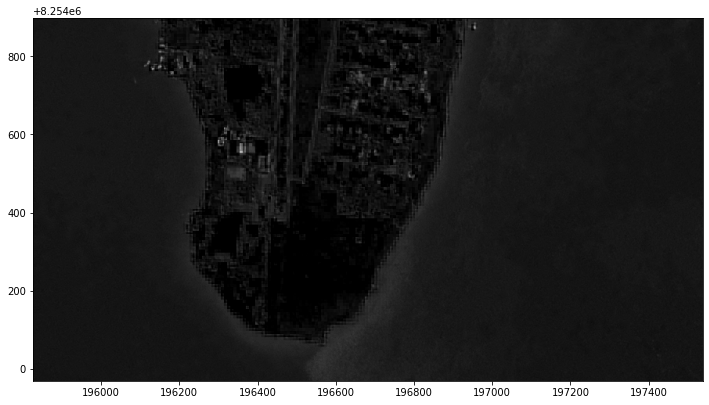

(0.0, 1.0, 0.0, 1.0)

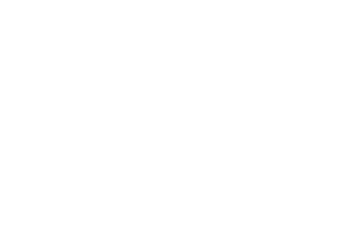

In [19]:
fig, ax = plt.subplots(figsize=(12,12))
show(EM3, cmap='gray', transform=affine)
plt.axis('off')

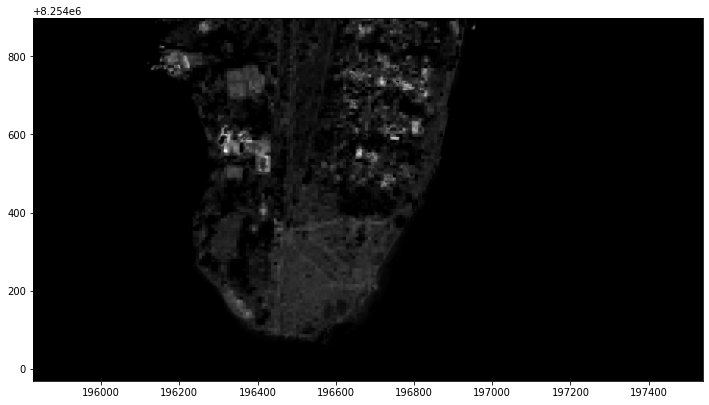

(0.0, 1.0, 0.0, 1.0)

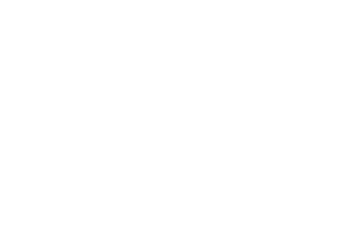

In [20]:
fig, ax = plt.subplots(figsize=(12,12))
show(EM4, cmap='gray', transform=affine)
plt.axis('off')

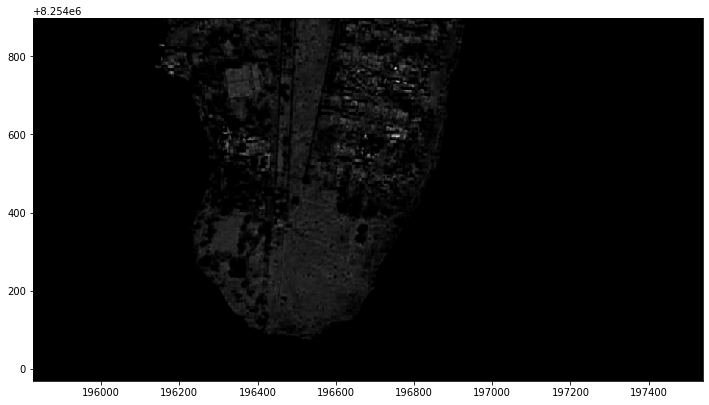

(0.0, 1.0, 0.0, 1.0)

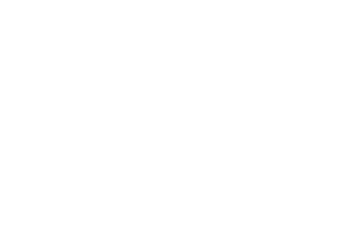

In [21]:
fig, ax = plt.subplots(figsize=(12,12))
show(EM5, cmap='gray', transform=affine)
plt.axis('off')

**7 - Visualize a composição das fraçoes escolhidas**

7.1 Apliquei uma funcao de contraste na imagem 

In [22]:
min_percent = 2   # Low percentile
max_percent = 98  # High percentile

def stretch_img(img):
  lo, hi = np.percentile(img, (min_percent, max_percent))
  res_img=(img.astype(float) - lo) / (hi-lo)
  return np.maximum(np.minimum(res_img*255, 255), 0).astype(np.uint8)

EM4c=stretch_img(EM4)
EM3c=stretch_img(EM3)
EM1c=stretch_img(EM1)

7.2 Plota a composição RGB das frações

(-0.5, 855.5, 463.5, -0.5)

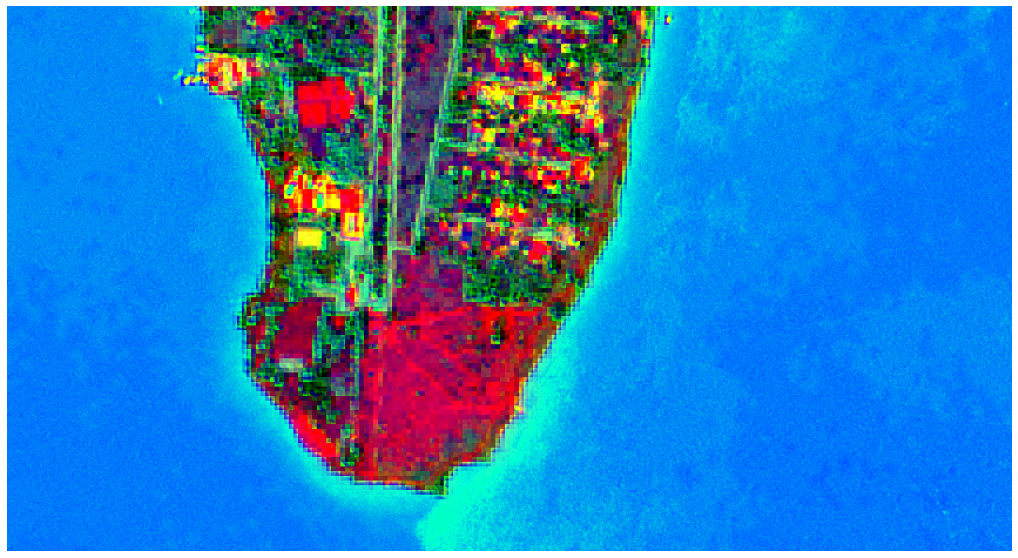

In [23]:
fig, ax = plt.subplots(figsize=(18,18))
rgb_composite_bn= np.dstack((EM4c, EM3c, EM1c))
plt.imshow(rgb_composite_bn)
plt.axis("off")